In [1]:
import numpy as np
import pandas as pd
import time
import graphviz
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import preprocessing
import copy

In [2]:
names = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","label"]

In [3]:
census_data = pd.read_csv('./adult.data',header = None,sep=', ',engine='python',na_values='?',names = names)
census_test = pd.read_csv('./adult.test',header = None,sep=', ',engine='python',na_values='?',skiprows=[0],names=names)

In [4]:
for i in range(census_test.shape[0]):
    census_test.iloc[i,-1]=census_test.iloc[i,-1].strip('.')

In [5]:
def Accuracy(predicted, truth):
    correct = 0
    for i in range(len(predicted)):
        if predicted[i]==truth.iloc[i]:
            correct +=1
    return correct/len(predicted)

In [6]:
#Preprocessing one-hot
# -Remove education column
# -Drop NAs
# -Splitting to feature and label sets
# -ONEHOT
def Preproc_ONEHOT(data_in,test_in):
    data = data_in.copy()
    test = test_in.copy()
    data = data.drop(["education"],axis = 1)
    test = test.drop(["education"],axis = 1)
    data = data.dropna()
    test = test.dropna()
    
    len_data = data.shape[0]
    len_test = test.shape[0]
    
    result = pd.concat([data,test])
    
    result_label = result.iloc[:,-1]
    result = result.iloc[:,:-1]
    
    categoricals = ["workclass","marital-status","occupation","relationship","race","sex","native-country"]

    for i in range(len(categoricals)):
        result[categoricals[i]]=pd.Categorical(result[categoricals[i]])
        onehot = pd.get_dummies(result[categoricals[i]], prefix = categoricals[i])
        result = result.drop([categoricals[i]],axis = 1)
        result = pd.concat([result, onehot], axis=1)
    
    data_feature = result.iloc[0:len_data,:]
    data_label = result_label.iloc[0:len_data]
    test_feature = result.iloc[len_data:,:]
    test_label = result_label.iloc[len_data:]
    
    return (data_feature,data_label,test_feature,test_label)   

In [7]:
data_feature, data_label,test_feature, test_label = Preproc_ONEHOT(census_data,census_test)

In [8]:
print("Minimum expected accuracy: "+str(data_label.value_counts().max()/data_label.value_counts().sum()*100))
print("Minimum expected accuracy: "+str(test_label.value_counts().max()/test_label.value_counts().sum()*100))

Minimum expected accuracy: 75.10775147536636
Minimum expected accuracy: 75.4316069057105


In [9]:
data_feature.shape

(30162, 88)

In [9]:
#Gini classifier
MAX_DEPTHS = [2,4,6,8,10,15,30]
MIN_LEAVES = [1,2,4,6,10,20,40,70,150,500,1000]
results = np.zeros((len(MAX_DEPTHS),len(MIN_LEAVES)))
traintime = np.zeros((len(MAX_DEPTHS),len(MIN_LEAVES)))
evaltime = np.zeros((len(MAX_DEPTHS),len(MIN_LEAVES)))

In [10]:
best_gini = None
best_acc = 0
for i in range(len(MAX_DEPTHS)):
    for j in range(len(MIN_LEAVES)):
        for helper in range(1):
            clf_gini = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                                   max_depth=MAX_DEPTHS[i], min_samples_leaf=MIN_LEAVES[j])
            currtime = time.time()
            clf_gini.fit(data_feature, data_label)
            traintime[i,j]+=time.time()-currtime
            currtime = time.time()
            prediction=clf_gini.predict(test_feature)
            evaltime[i,j]+=time.time()-currtime
            results[i,j]+=Accuracy(prediction,test_label)
        if results[i,j]>best_acc:
            best_acc=results[i,j]
            best_gini=copy.deepcopy(clf_gini)

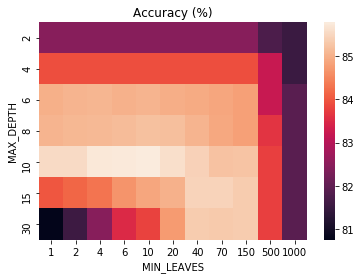

In [11]:
sbn.heatmap(results*100,xticklabels=MIN_LEAVES,yticklabels=MAX_DEPTHS)
plt.xlabel("MIN_LEAVES")
plt.ylabel("MAX_DEPTH")
plt.title("Accuracy (%)")
plt.savefig("CensusIncome_Acc_gini.png")

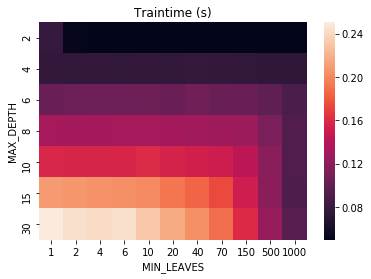

In [12]:
sbn.heatmap(traintime/1,xticklabels=MIN_LEAVES,yticklabels=MAX_DEPTHS)
plt.xlabel("MIN_LEAVES")
plt.ylabel("MAX_DEPTH")
plt.title("Traintime (s)")
plt.savefig("CensusIncome_Train_gini.png")

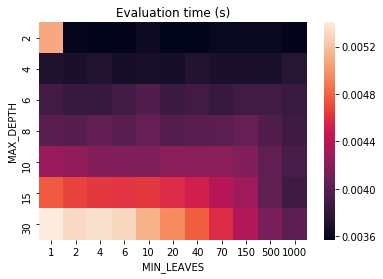

In [13]:
sbn.heatmap(evaltime/1,xticklabels=MIN_LEAVES,yticklabels=MAX_DEPTHS)
plt.xlabel("MIN_LEAVES")
plt.ylabel("MAX_DEPTH")
plt.title("Evaluation time (s)")
plt.savefig("CensusIncome_Eval_gini.png")

In [14]:
#With this we can make fancy pictures to show in presentation if we want to present this, also looks cool in the report

dot_data = tree.export_graphviz(best_gini, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("CensusIncome_GiniTree") 

'CensusIncome_GiniTree.pdf'

In [15]:
from sklearn.metrics import confusion_matrix
prediction=best_gini.predict(test_feature)
confusion_matrix(test_label, prediction)

array([[10700,   660],
       [ 1483,  2217]])

In [16]:
#Entropy classifier
MAX_DEPTHS = [2,4,6,8,10,15,30]
MIN_LEAVES = [1,2,4,6,10,20,40,70,150,500,1000]
results = np.zeros((len(MAX_DEPTHS),len(MIN_LEAVES)))
traintime = np.zeros((len(MAX_DEPTHS),len(MIN_LEAVES)))
evaltime = np.zeros((len(MAX_DEPTHS),len(MIN_LEAVES)))

In [17]:
best_entrop = None
best_acc = 0
for i in range(len(MAX_DEPTHS)):
    for j in range(len(MIN_LEAVES)):
        for helper in range(1):
            clf_gini = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                                   max_depth=MAX_DEPTHS[i], min_samples_leaf=MIN_LEAVES[j])
            currtime = time.time()
            clf_gini.fit(data_feature, data_label)
            traintime[i,j]+=time.time()-currtime
            currtime = time.time()
            prediction=clf_gini.predict(test_feature)
            evaltime[i,j]+=time.time()-currtime
            results[i,j]+=Accuracy(prediction,test_label)
        if results[i,j]>best_acc:
            best_acc=results[i,j]
            best_entrop=copy.deepcopy(clf_gini)

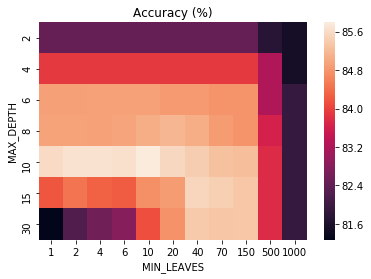

In [18]:
sbn.heatmap(results*100,xticklabels=MIN_LEAVES,yticklabels=MAX_DEPTHS)
plt.xlabel("MIN_LEAVES")
plt.ylabel("MAX_DEPTH")
plt.title("Accuracy (%)")
plt.savefig("CensusIncome_Acc_entrop.png")

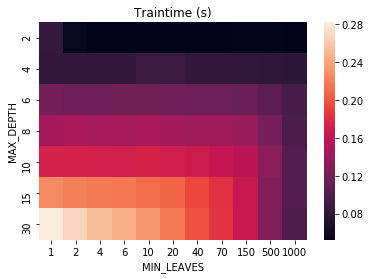

In [19]:
sbn.heatmap(traintime/1,xticklabels=MIN_LEAVES,yticklabels=MAX_DEPTHS)
plt.xlabel("MIN_LEAVES")
plt.ylabel("MAX_DEPTH")
plt.title("Traintime (s)")
plt.savefig("CensusIncome_Train_entrop.png")

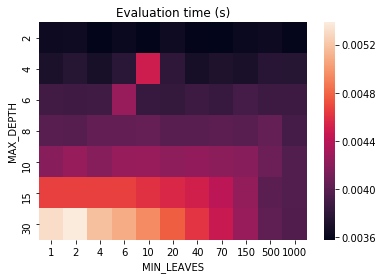

In [20]:
sbn.heatmap(evaltime/1,xticklabels=MIN_LEAVES,yticklabels=MAX_DEPTHS)
plt.xlabel("MIN_LEAVES")
plt.ylabel("MAX_DEPTH")
plt.title("Evaluation time (s)")
plt.savefig("CensusIncome_Eval_entrop.png")

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_label, prediction)

array([[10545,   815],
       [ 1908,  1792]])

In [22]:
#With this we can make fancy pictures to show in presentation if we want to present this, also looks cool in the report

dot_data = tree.export_graphviz(best_entrop, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("CensusIncome_EntropyTree") 

'CensusIncome_EntropyTree.pdf'

In [23]:
from sklearn.metrics import confusion_matrix
prediction=best_entrop.predict(test_feature)
confusion_matrix(test_label, prediction)

array([[10803,   557],
       [ 1583,  2117]])